Contact me [@kamilchmielu](https://twitter.com/kamilchmielu)

# Z3 Solver for dummies

In an effort to understand how tools like [Solidity SMT Checker](https://docs.soliditylang.org/en/v0.8.20/smtchecker.html), [Manticore](https://github.com/trailofbits/manticore) or [Halmos](https://github.com/a16z/halmos) work I decided to go straight to the source. Most of these tools use (or can use) Z3 under the hood. This document is part of me going backwards in the innerworkings of the current Formal Verification tooling.

I am neither an expert in FV or in maths. I am just a curious mind.

## Learning materials

Everything I know about Z3 comes from these resources: 
- [Programming Z3](https://theory.stanford.edu/~nikolaj/programmingz3.html)
- [SAT/SMT by Example, Dennis Yurichev](https://sat-smt.codes/SAT_SMT_by_example.pdf)
- [Z3Py guide](https://ericpony.github.io/z3py-tutorial/guide-examples.htm)

In [1]:
from z3 import *

## Z3 as a calculator

You can think of Z3 solver as of calculator, that's it. You feed it with some equations and it will solve them. 

### Solving equations

In [2]:
x = Int('x')
y = Int('y')
solve(x > 2, y < 10, x + 2*y == 7)

[y = 0, x = 7]


To be more precise, `x > 2`, `y < 10` and `x + 2 * y == 7` are viewed as constrains. Z3 is looking for an answer that satisfies these constrains.

### Simplifying equations

In [3]:
# Using Ints instead of Int makes the code examples more concise
x, y = Ints('x y')
print (simplify(x + y + 2*x + 3))
print (simplify(x < y + x + 2))
print (simplify(And(x + 1 >= 3, x**2 + x**2 + y**2 + 2 >= 5)))

3 + 3*x + y
Not(y <= -2)
And(x >= 2, 2*x**2 + y**2 >= 3)


### Adding constraints

**Example from [SAT/SMT by example, chapter 3.2](https://sat-smt.codes/SAT_SMT_by_example.pdf)**

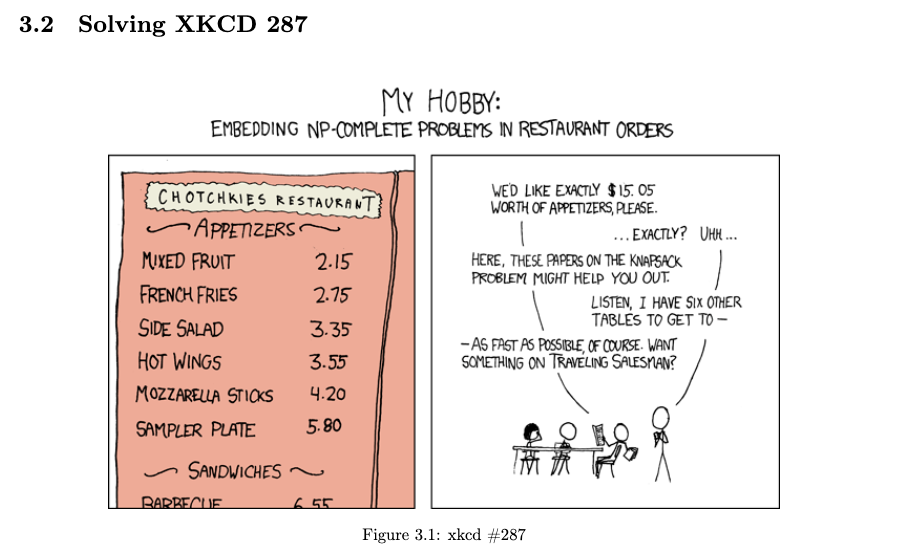

You are in a restaurant and want to buy appetizers exactly for `$15.05`. Using Z3 it is as simple as solving an equation with 6 variables, lol.

*Whenever you call the `add()` method on the `Solver`, you add the constrain. It is referred to as **asserting the constraint**.*

In [4]:
fruit, fries, salad, wings, sticks, plate = Ints('fruit fries salad wings sticks plate')

s = Solver()
s.add(fruit * 2.15 + fries * 2.75 + salad * 3.35 + wings * 3.55 + sticks * 4.20 + plate * 5.80 == 15.05)

s.check()
s.model()

[sticks = 0,
 fruit = -109,
 salad = 0,
 plate = 43,
 wings = 0,
 fries = 0]

As you can clearly see, my initial thought was not entirely correct. You can't really order `-11` mozarella sticks. I probably have to add another constrain to make sure that orders are `>= 0`. 

Another question is in my mind:
- How does Z3 treat floating point numbers? I've mindlessly used the `Ints` type with numbers like `2.15`. However judging by the initial results it is doing the calculations correctly. They sum up to `15.05`.

## Practical blockchain examples

### An example from [Constraint Solving for Program Analysis by Certora](https://youtu.be/9kKA4uBRqVo?t=1179)

The **Code** that we want to test:
```js
transfer (address from, address to, uint256 amount) { 
    require (balances [from] ≥ amount); 
    balancesFrom := balances [from] - amount; 
    balancesTo := balances [to] + amount; 
    balances [from] := balancesFrom; 
    balances [to] := balancesTo; 
}
```

An **Invariant** that we want to check:
- The sum of the balances remains constant.